In [ ]:
# Bibliotecas
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

!pip install -q shap
import shap

!pip install -q ucimlrepo
from ucimlrepo import fetch_ucirepo

In [ ]:
# Carregar o conjunto "Wine quality"
from ucimlrepo import fetch_ucirepo

wine_quality = fetch_ucirepo(id=186)

X = wine_quality.data.features
Y = wine_quality.data.targets

# Reduzir Y para uma dimensão
Y = Y.values.ravel()

# print(wine_quality.metadata)
print(wine_quality.variables)

# Divisão entre amostras de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(Y_train.shape)

# print(X)
# print(Y)

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non

In [ ]:
# Plot das variáveis independentes e resposta
plt.figure(figsize=(12, 10))

for i, column in enumerate(X_train.columns):
    plt.subplot(4, 4, i + 1)
    plt.hist(X_train[column], bins=30, color='skyblue', edgecolor='black')
    plt.title(column)

plt.subplot(4, 4, X_train.shape[1] + 1)
plt.hist(Y_train, bins=30, color='orange', edgecolor='black')
plt.title("Target Variable")

plt.tight_layout()
plt.show()

In [ ]:
# Criar o regressor random forest
model = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42, verbose=1)

# Treinar usando o conjunto de treino
model.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   15.2s


RandomForestRegressor(n_estimators=500, random_state=42, verbose=1)

In [ ]:
# Conjunto de hiperparâmetros
param_grid = {
    'n_estimators': [500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Treino/Teste usando o R2 como métrica
r2_scorer = make_scorer(r2_score)

model = RandomForestRegressor(random_state=42, verbose=1)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=r2_scorer, n_jobs=-1, verbose=1)

grid_search.fit(X_train, Y_train)

print("Melhor conjunto de hiperparâmetros:")
print(grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   15.2s


Melhor conjunto de hiperparâmetros:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


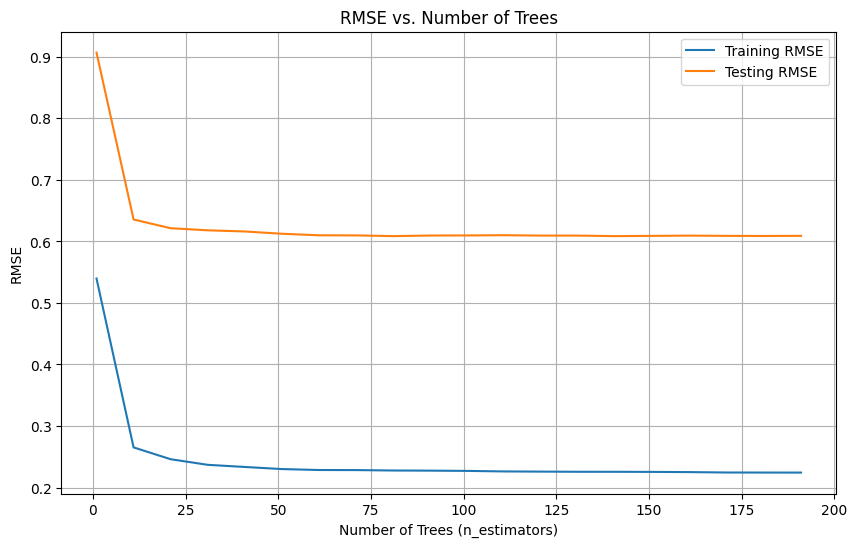

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output

train_rmse_values = []
test_rmse_values = []

for n_estimators in range(1, 201, 10):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=None, min_samples_split=2, min_samples_leaf=1, n_jobs=-1, random_state=42)
    model.fit(X_train, Y_train)

    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

    train_rmse_values.append(train_rmse)
    test_rmse_values.append(test_rmse)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 201, 10), train_rmse_values, label='Training RMSE')
plt.plot(range(1, 201, 10), test_rmse_values, label='Testing RMSE')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Prever os preços usando o conjunto de teste
Y_pred = model.predict(X_test)

# Cálculo das métricas
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE:", rmse)

mae = mean_absolute_error(Y_test, Y_pred)
print("MAE:", mae)

r2 = r2_score(Y_test, Y_pred)
print("R2", r2)

RMSE: 0.6073102793338965
MAE: 0.43598
R2 0.5006060515453346


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s


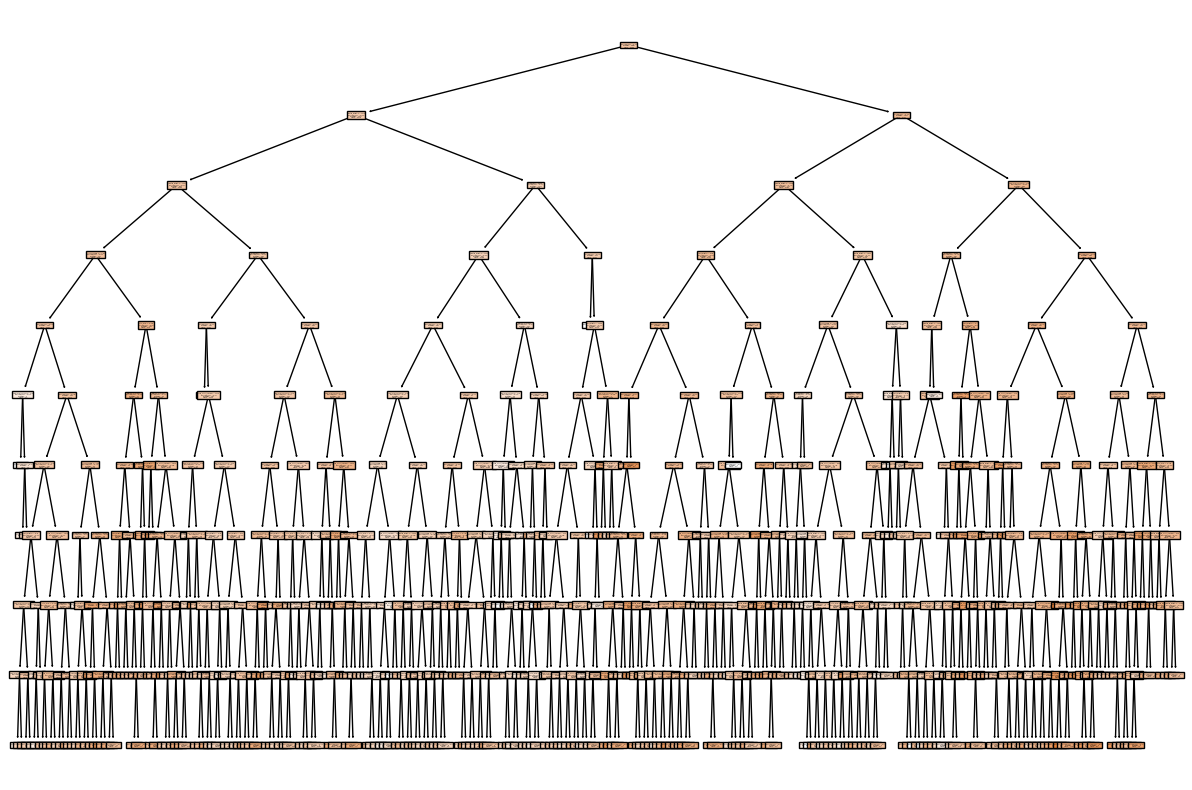

In [ ]:
# Visualização das árvores (escolher o número da árvore)
plt.figure(figsize=(15, 10))
plot_tree(model.estimators_[0], feature_names=X.columns, filled=True)
plt.show()

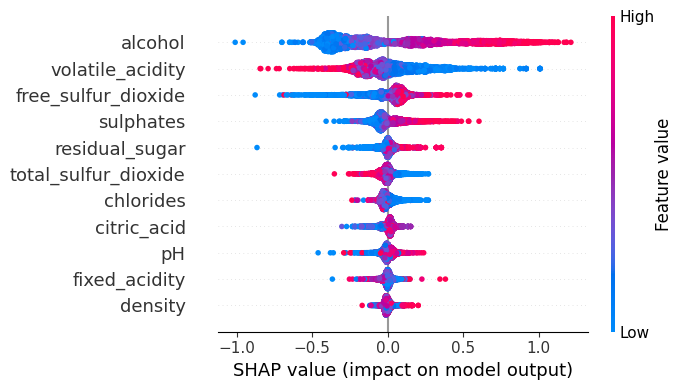

In [ ]:
# Interpretação do modelo usando SHAP
explainer = shap.TreeExplainer(model)

# Cáculo dos valores SHAP
shap_values = explainer.shap_values(X)

# Visualização (resumo)
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_size=[7, 4])

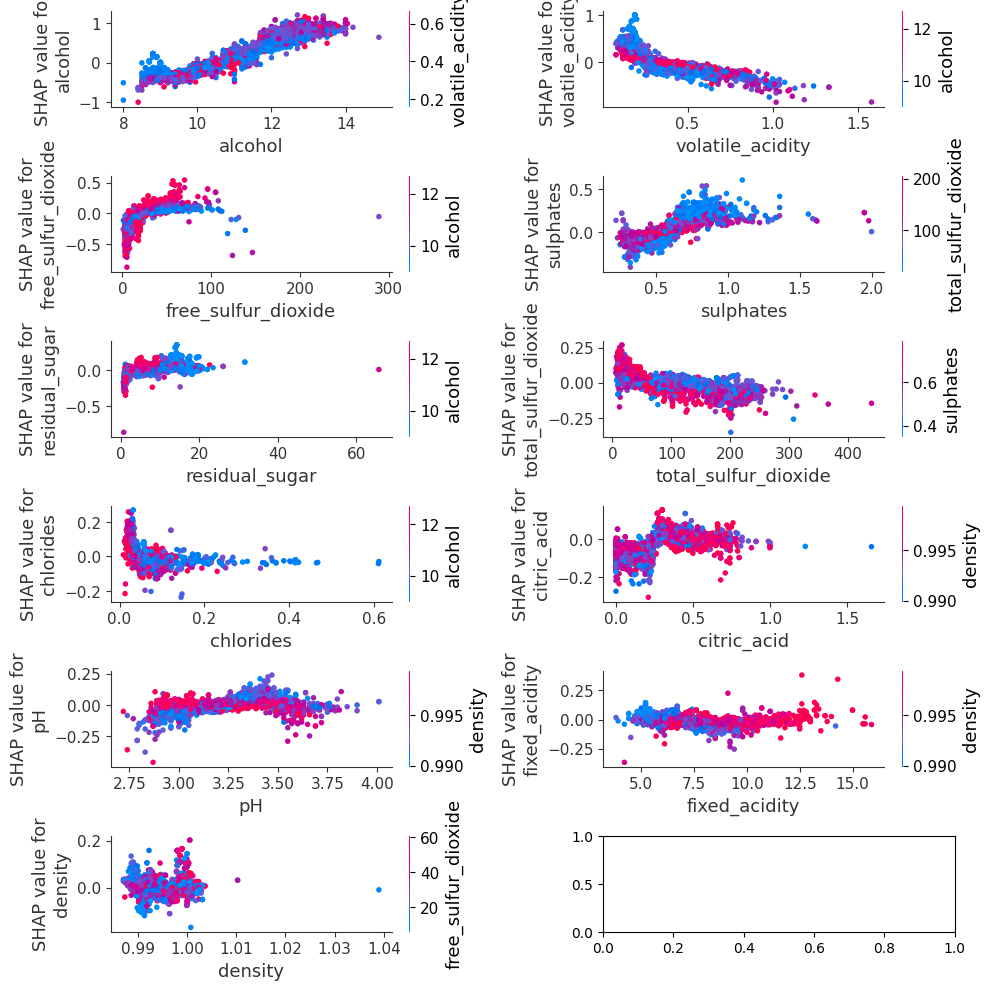

In [ ]:
# Visualização (gráficos de dependência)

# Ordenar as variáveis por ordem de importância
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 10))
axes = axes.ravel()

for i, col in enumerate(top_inds):
    shap.dependence_plot(top_inds[i], shap_values, X, ax=axes[i], feature_names=X.columns, show=False)

plt.tight_layout()
plt.show()